# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. We'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. Our goal is to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.duplicated().value_counts()

False    47331
dtype: int64

No duplicated values.

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

We have two null values each in average_rating and votes. Because this is a small sample of the data, we will remove those rows.

In [7]:
df_reviews = df_reviews.dropna()

In [8]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

We have handled our missing and dupicate values.

## EDA

Let's check the number of movies and reviews over years.

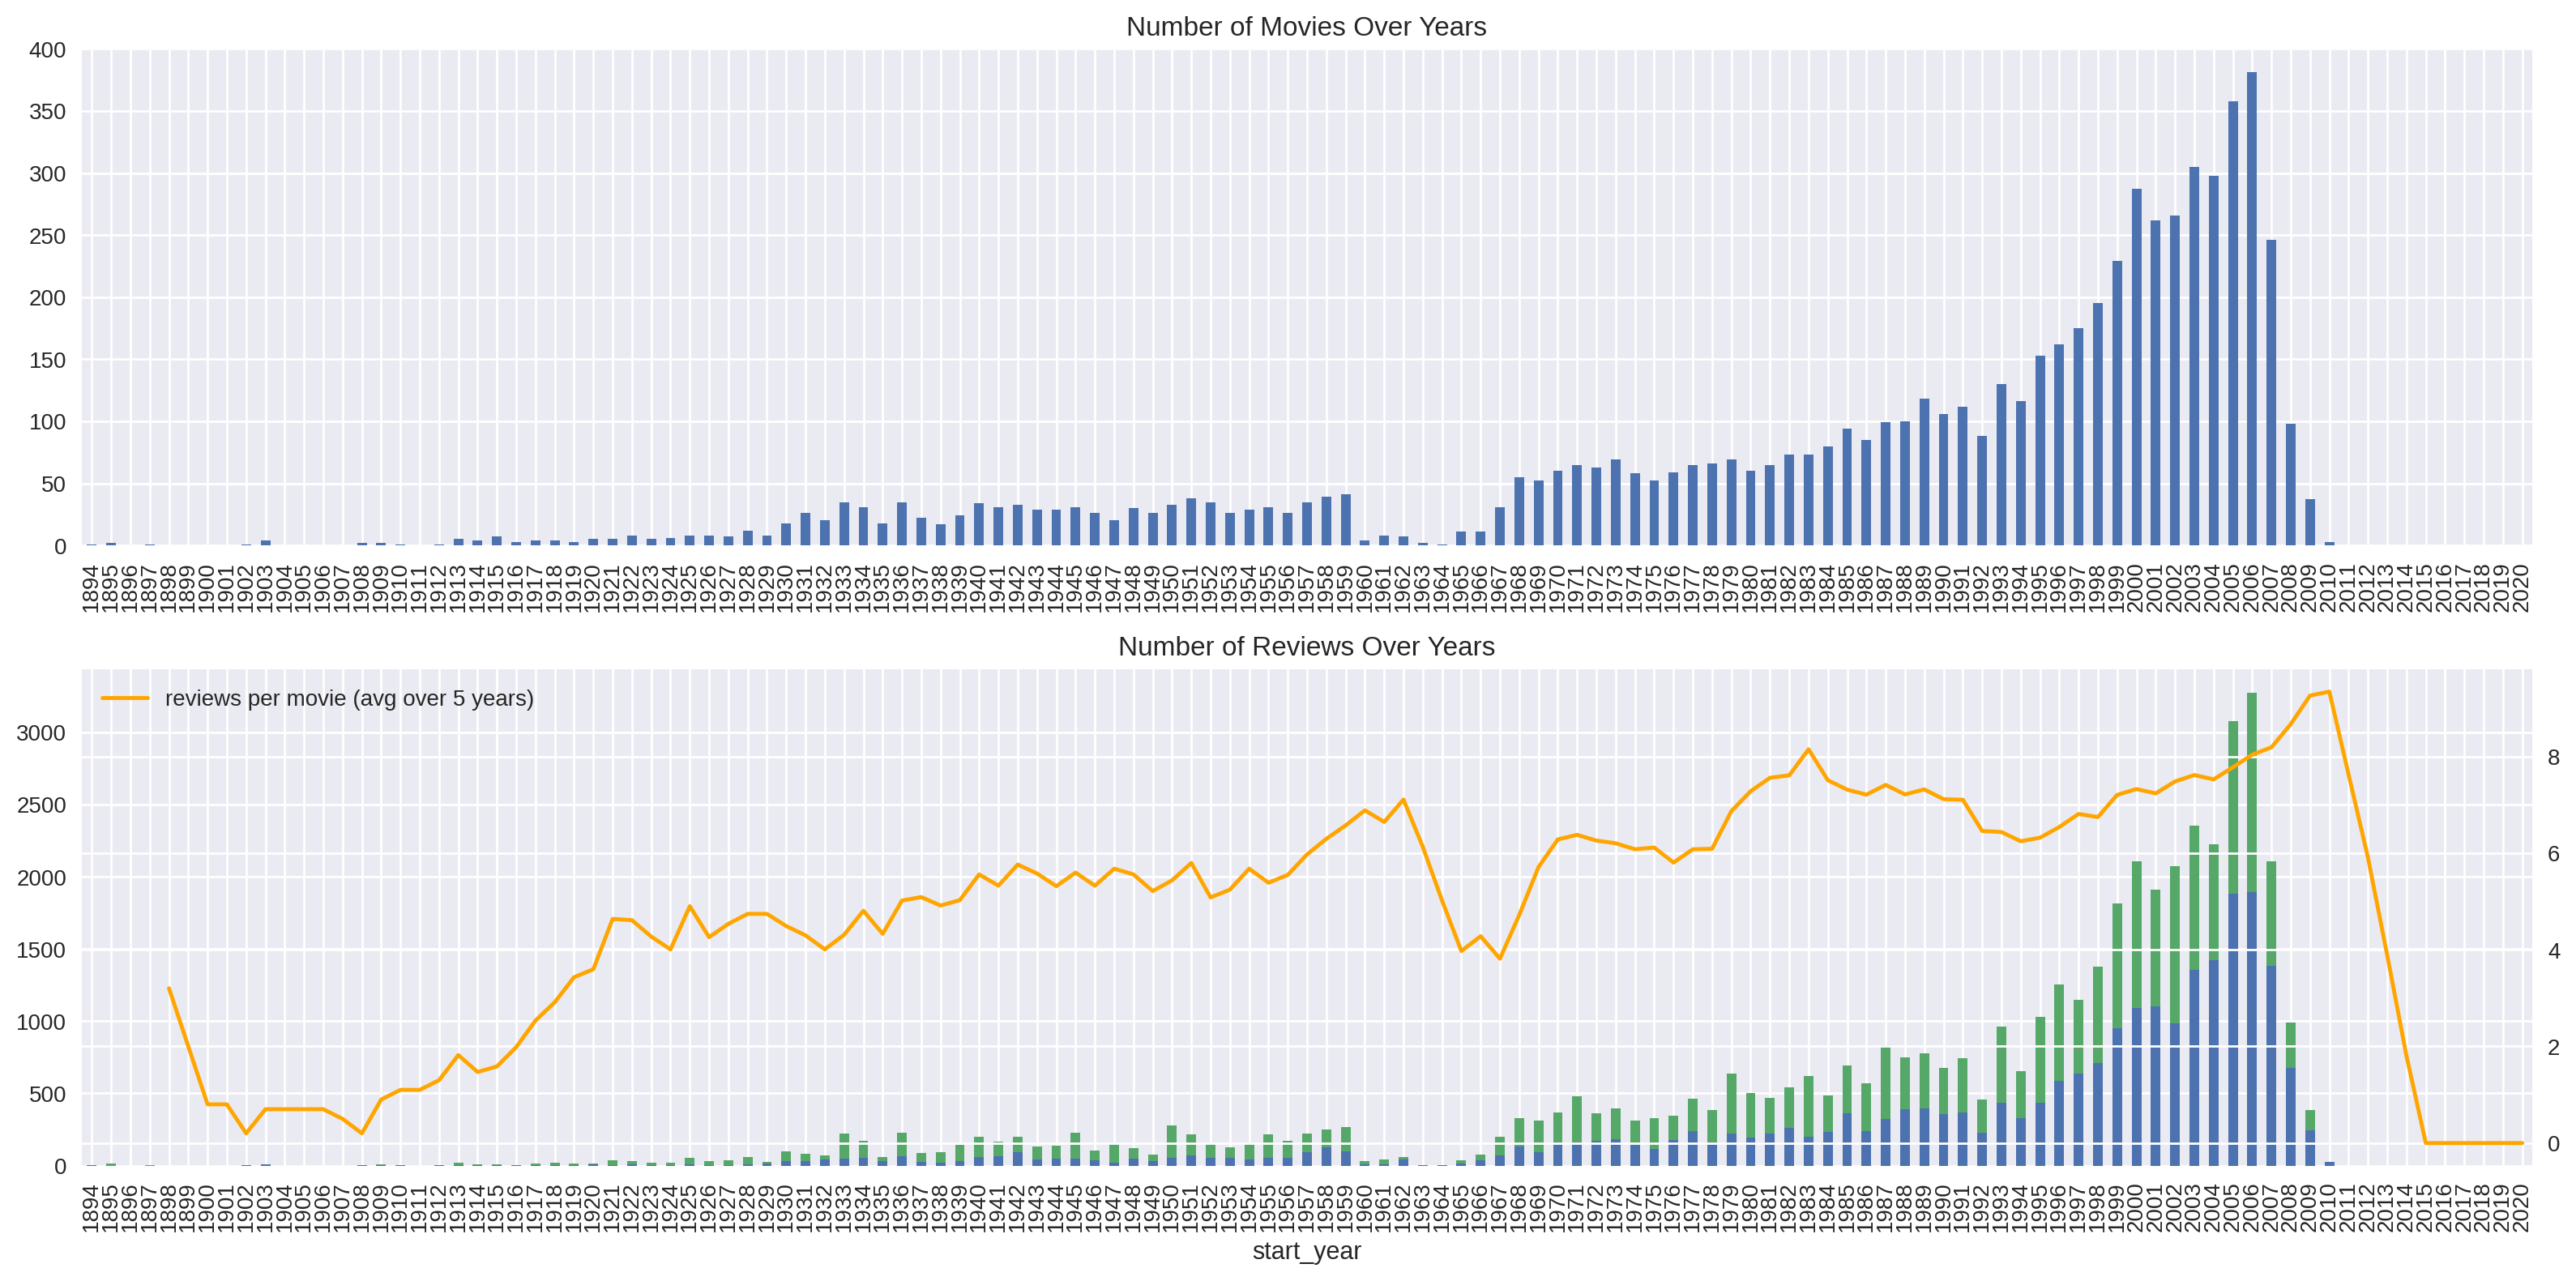

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

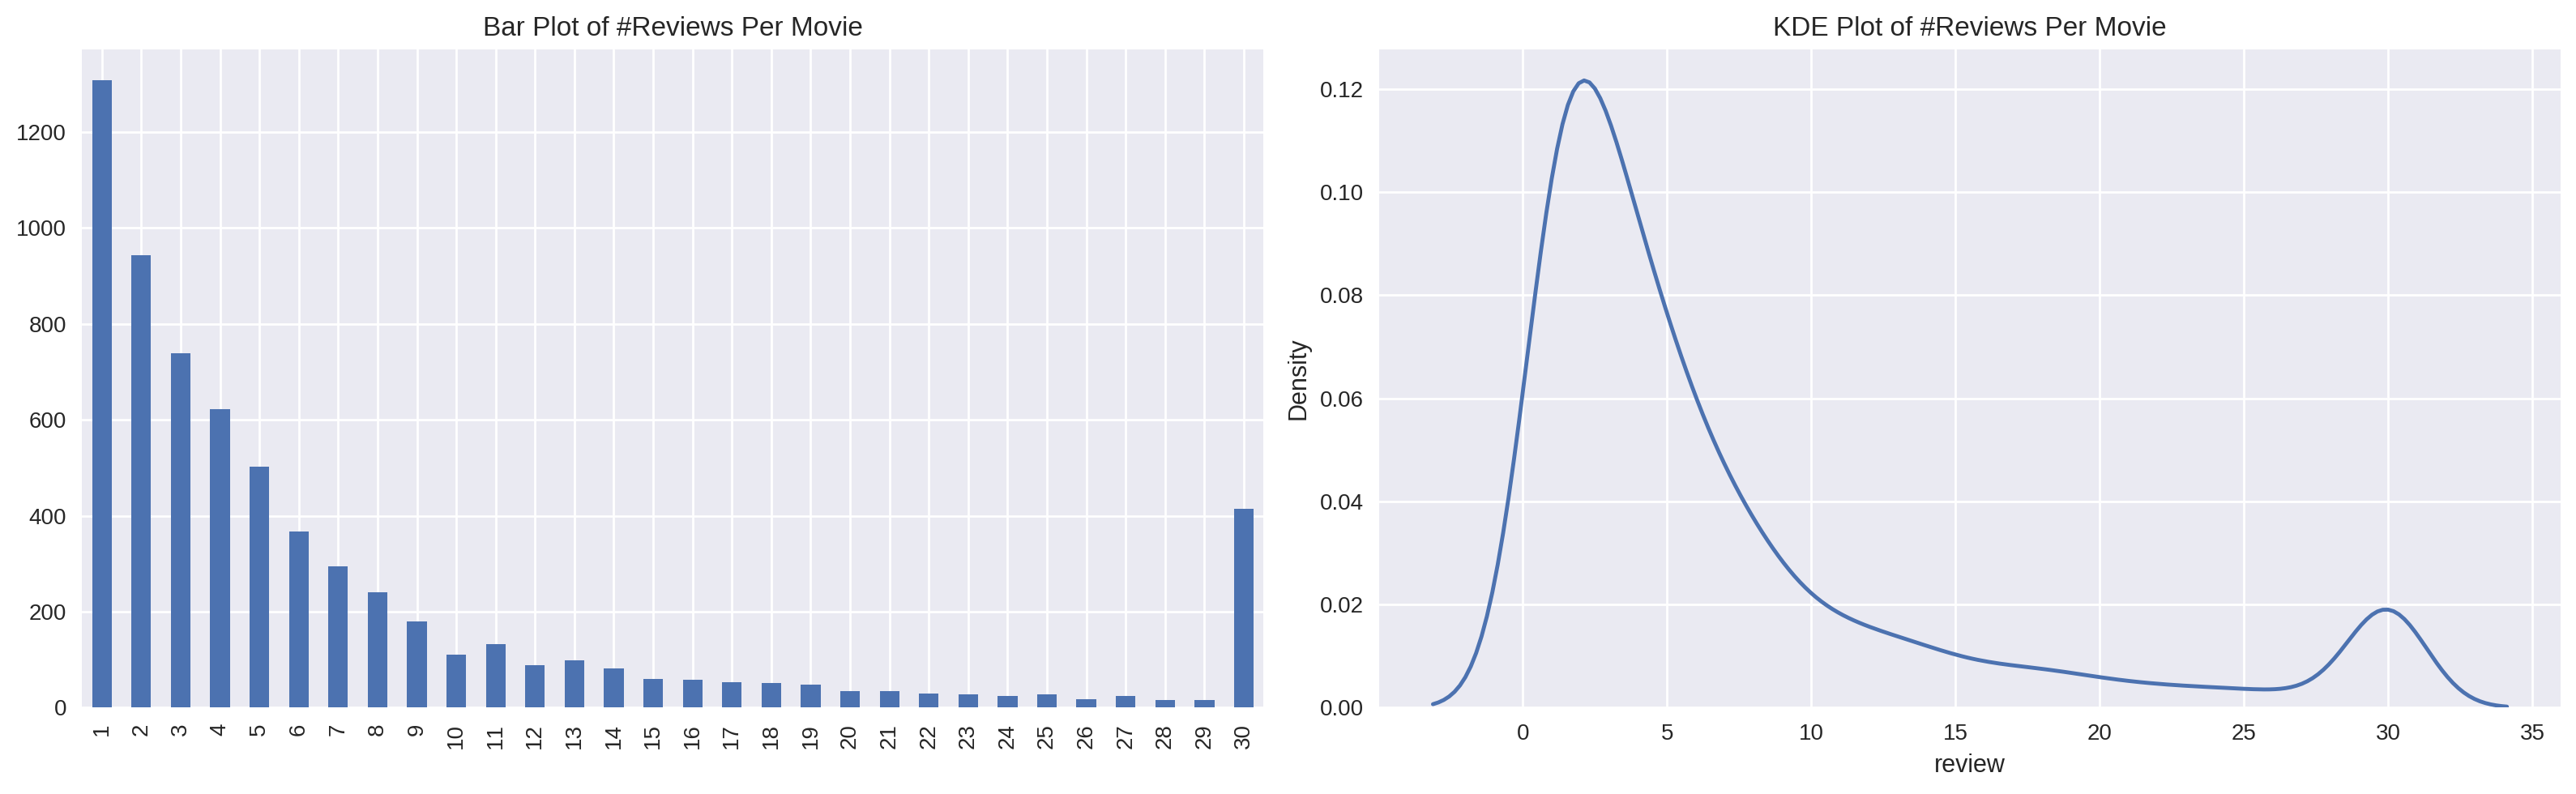

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

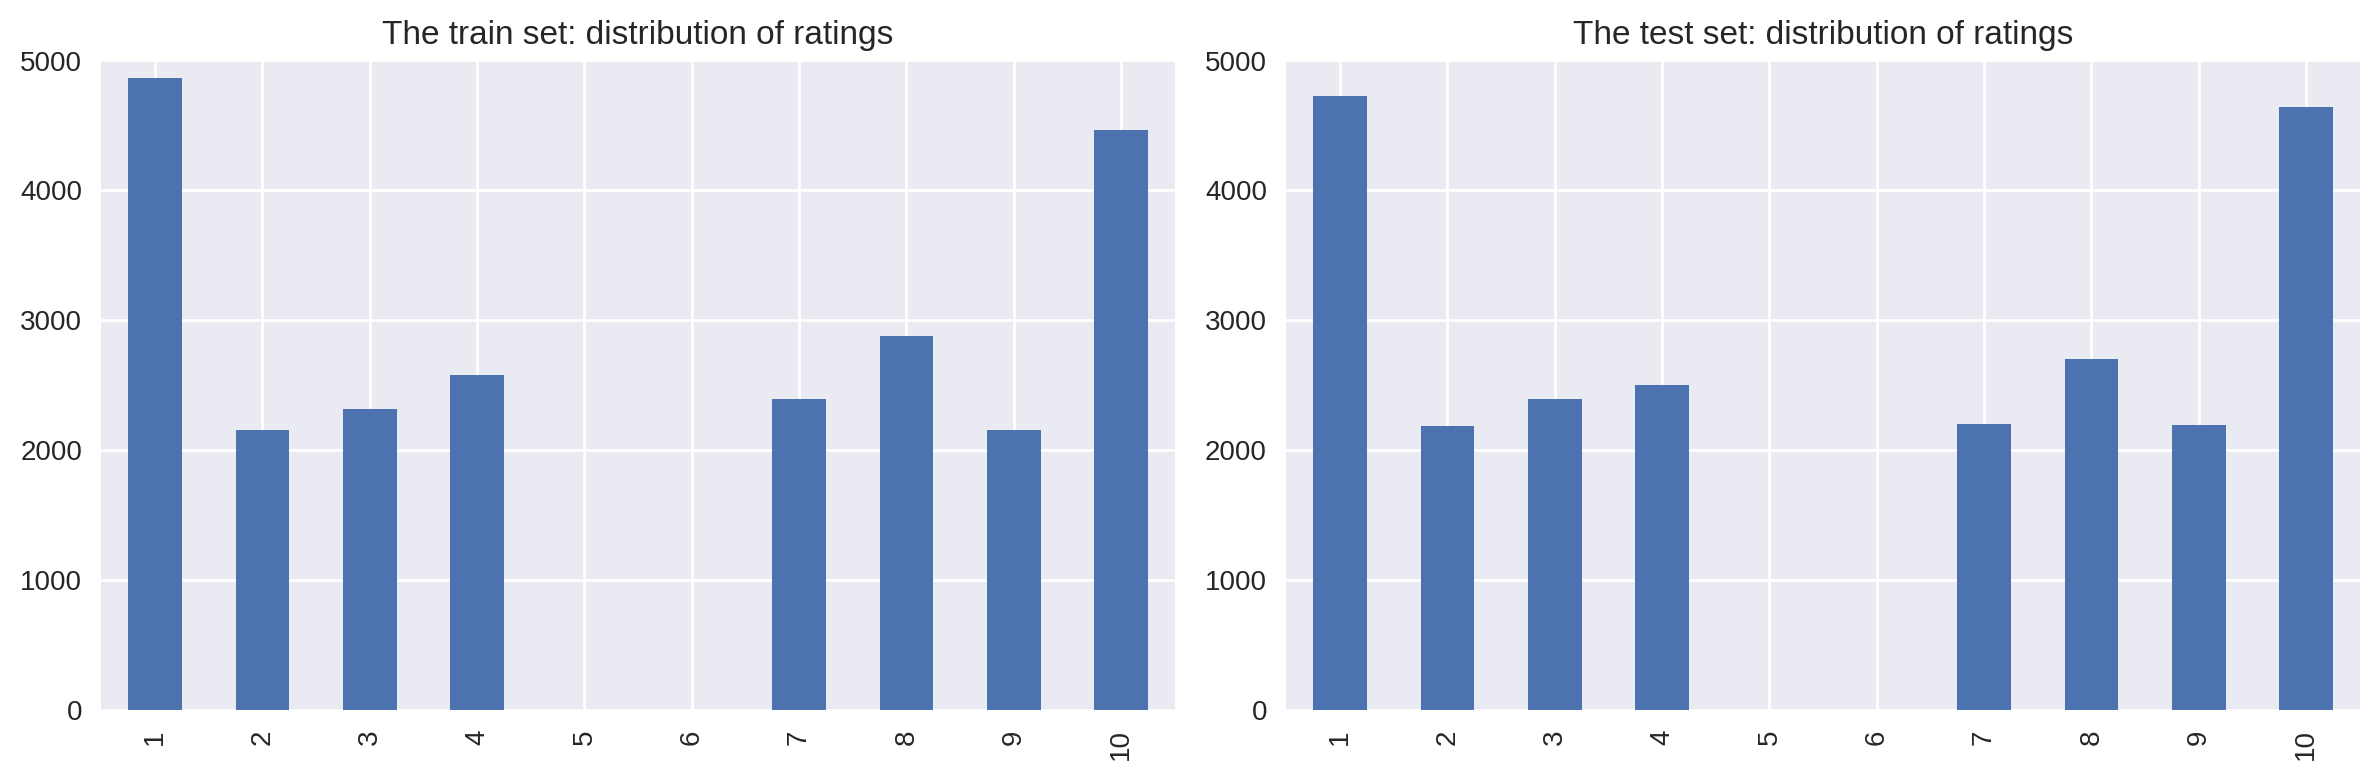

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


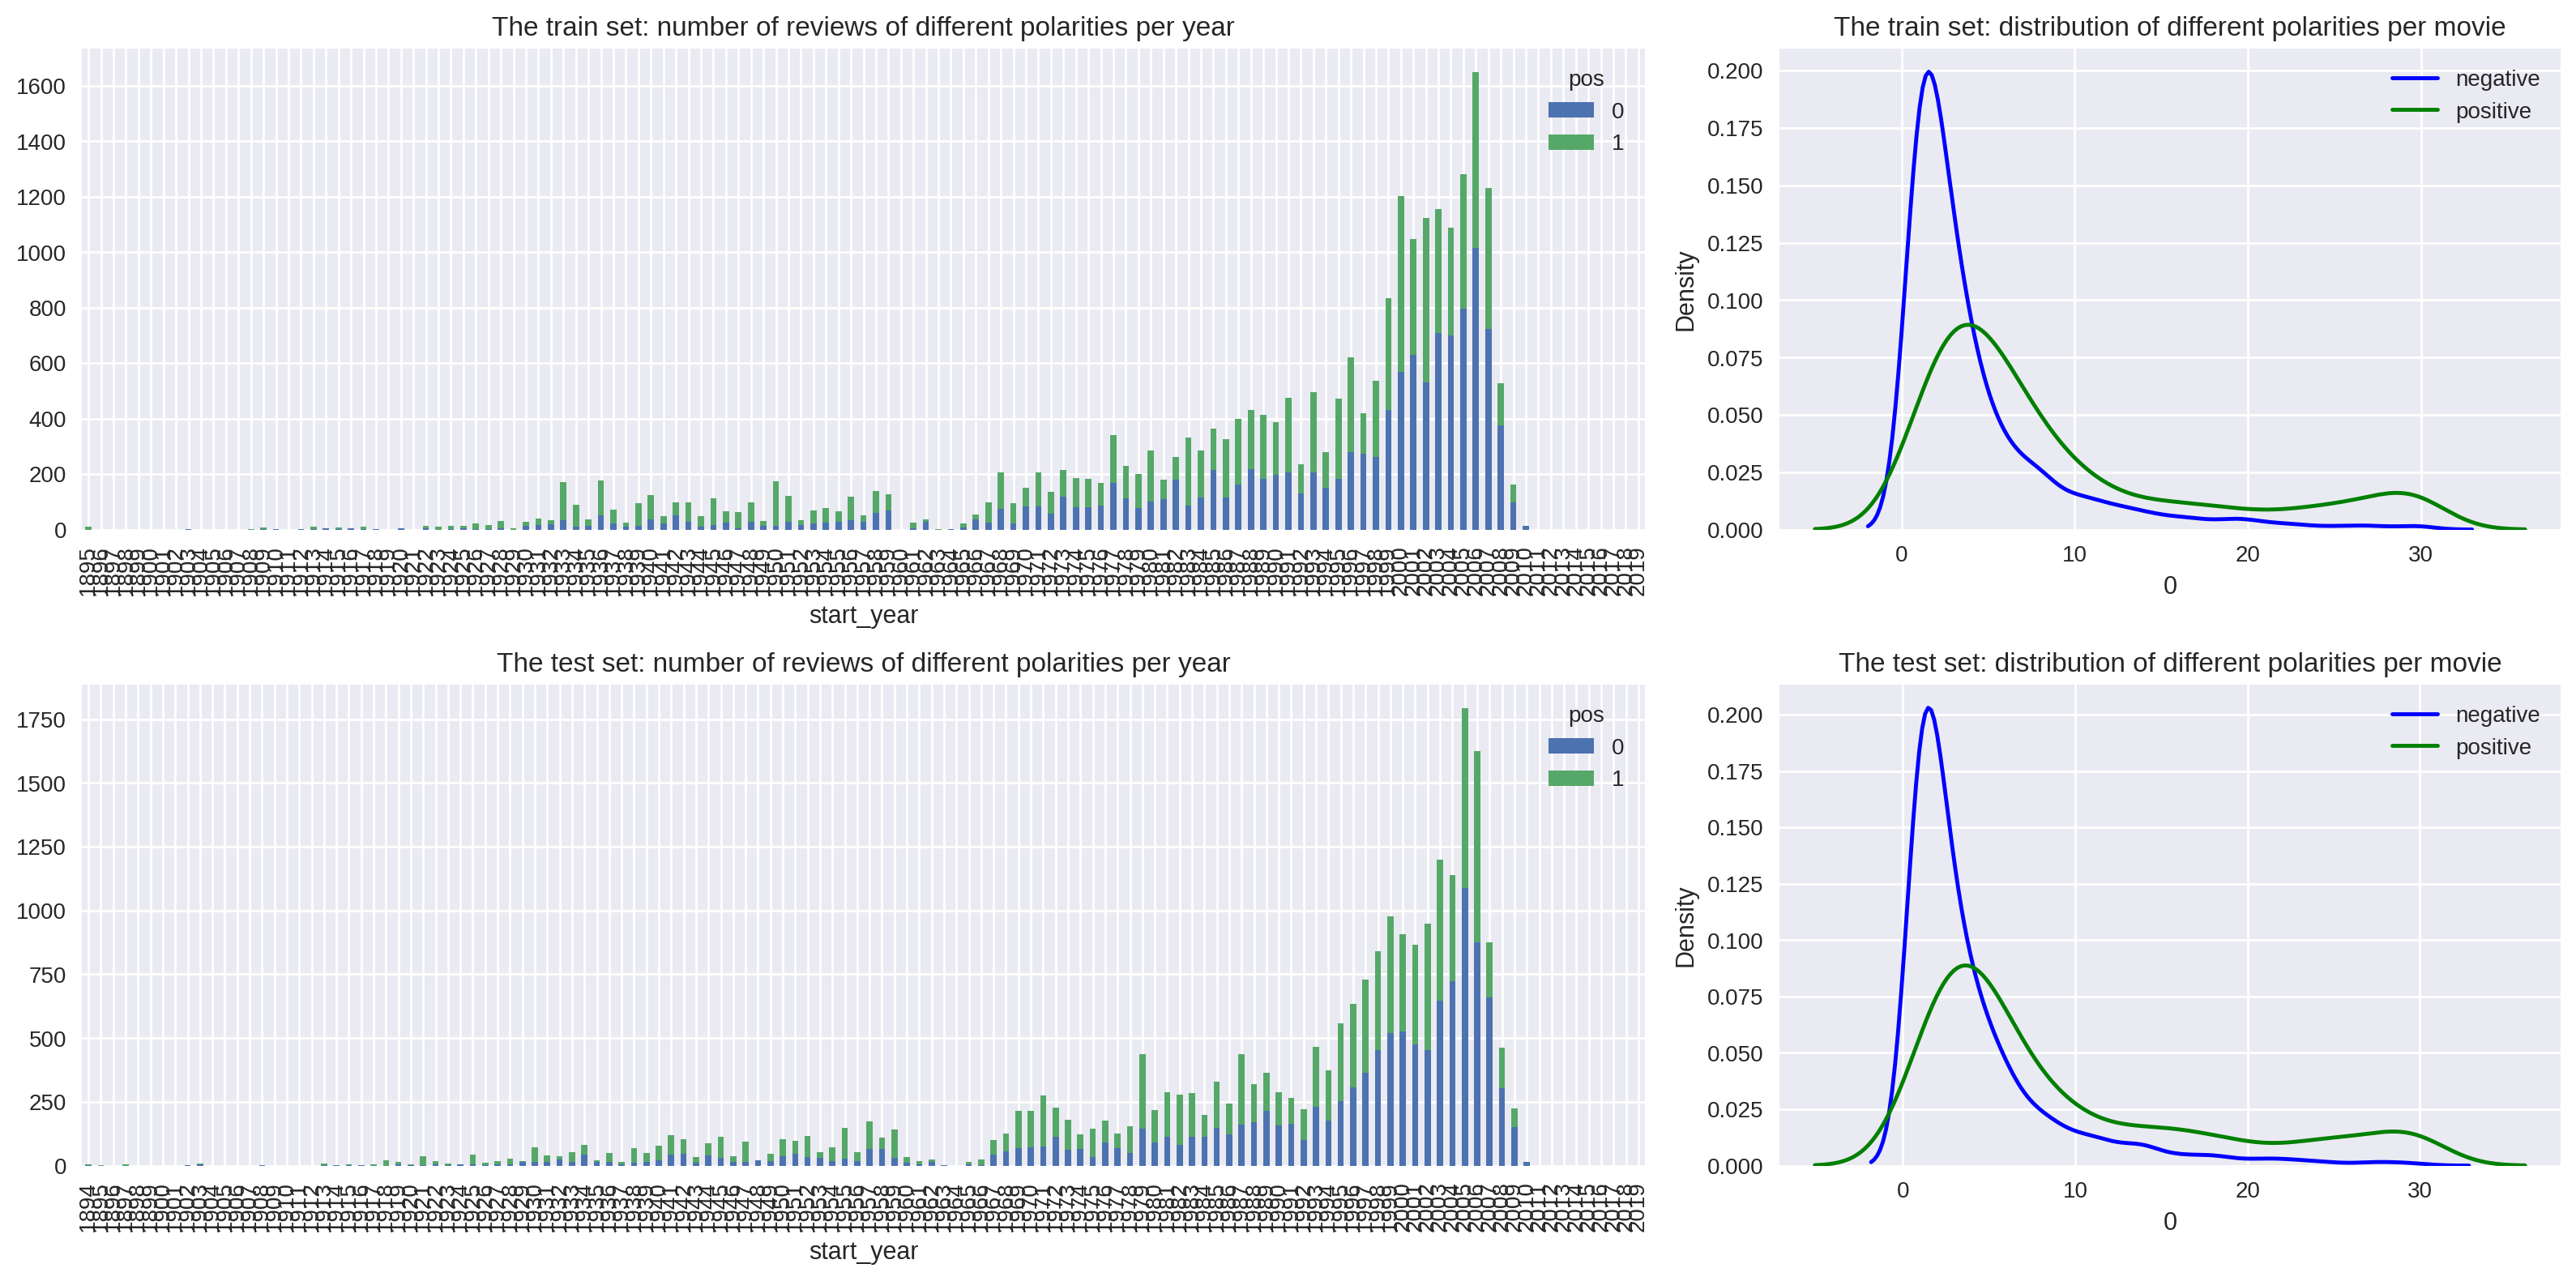

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [14]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [15]:
import re
                                                                        
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: re.sub(r"[^a-z\s']", '', x.lower()))


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Working with models

### Model 0 - Constant

In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

In [18]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(df_reviews_train.drop(columns=['pos']), train_target)
dummy_preds = dummy_clf.predict(df_reviews_test.drop(columns=['pos']))

In [19]:
f1 = f1_score(test_target, dummy_preds)
print(f"Dummy Classifier F1 Score: {f1:.2f}")

Dummy Classifier F1 Score: 0.00


### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [20]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [21]:
vectorizer = TfidfVectorizer(stop_words='english')

train_features_1 = vectorizer.fit_transform(df_reviews_train['review_norm'])

test_features_1 = vectorizer.transform(df_reviews_test['review_norm'])

In [22]:
model_1 = LogisticRegression(max_iter=1000, random_state=42)

model_1.fit(train_features_1, train_target)

LogisticRegression(max_iter=1000, random_state=42)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


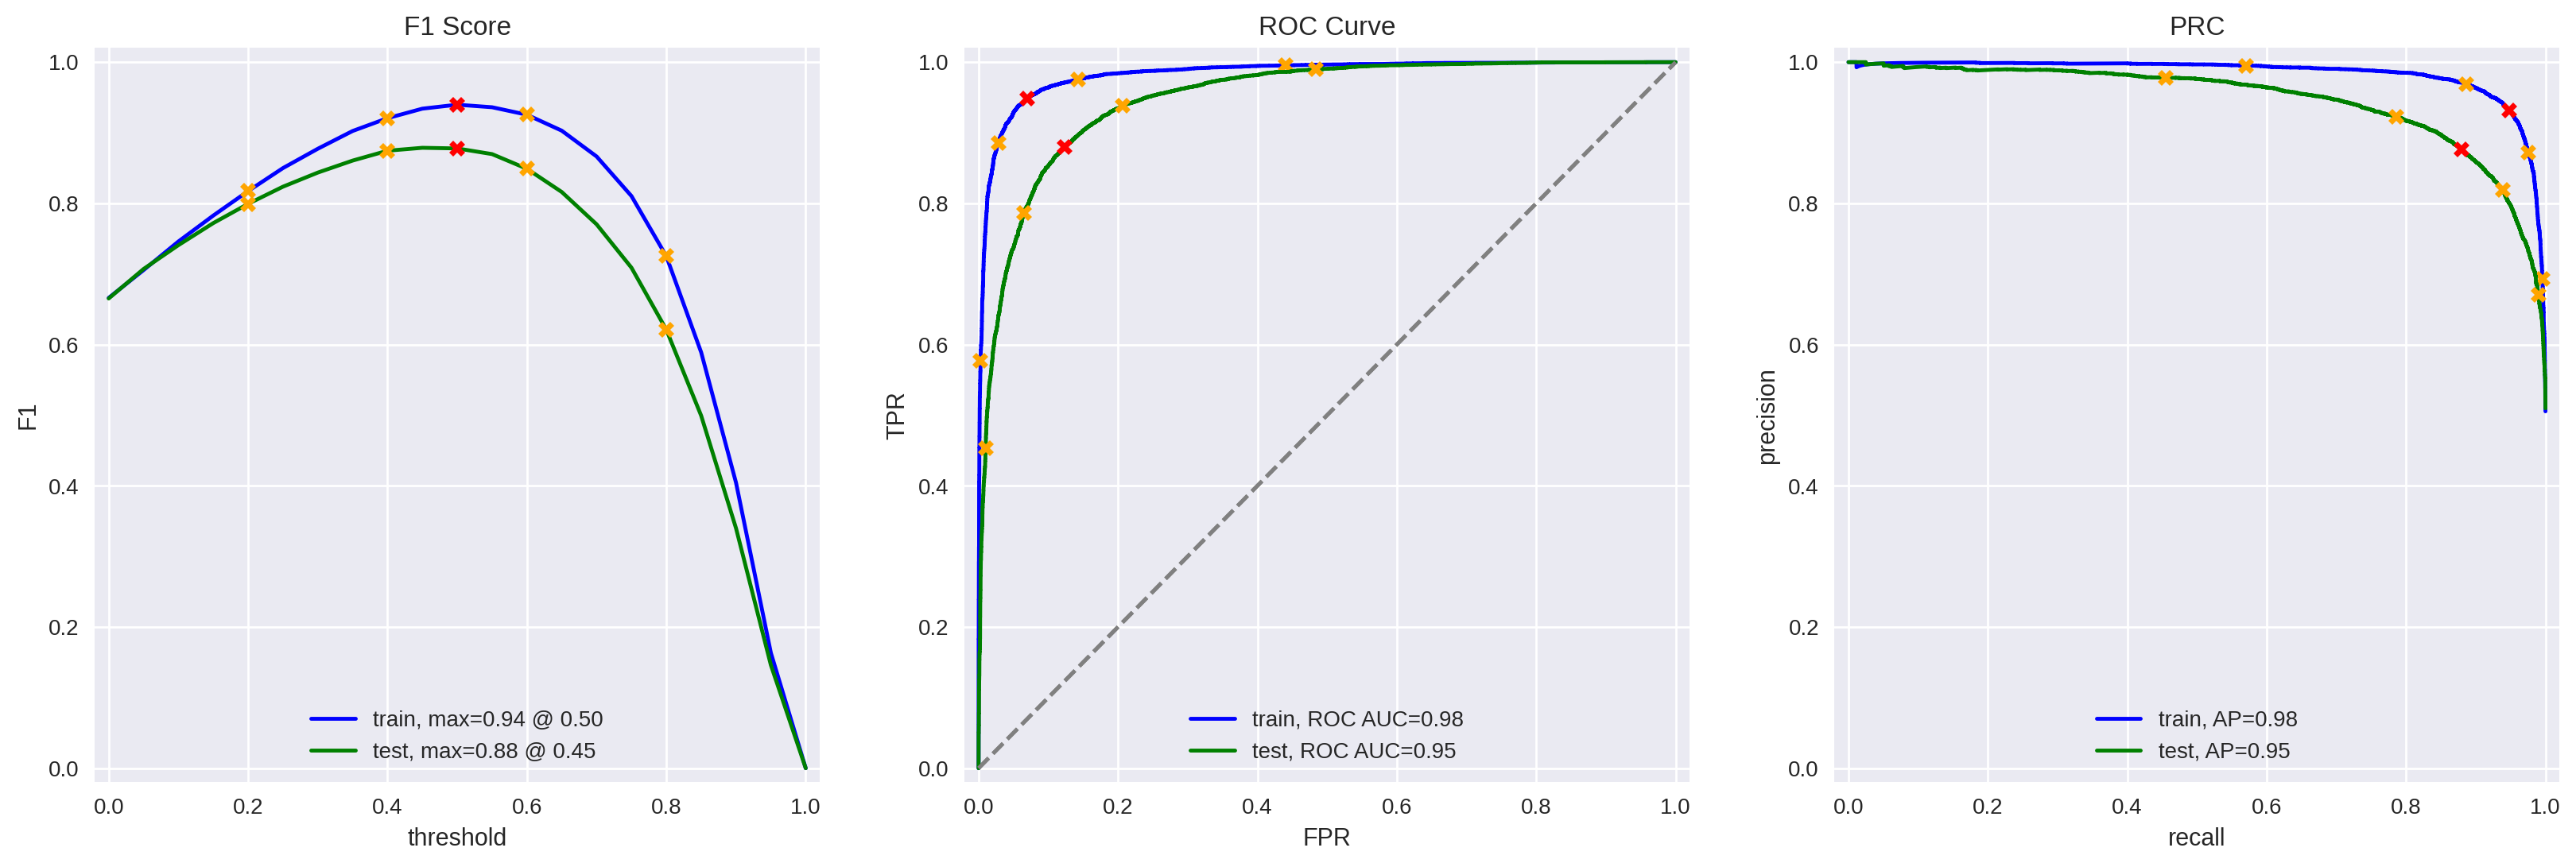

In [23]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

We are looking for an F1 score over 0.85, which we have accomplished. Mild overfitting is visible, but given the strong F1 test, minimal regularization adjustment is sufficient if needed.We will compare with the other models.

### Model 3 - spaCy, TF-IDF and LR

In [24]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'tagger'])

In [25]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [26]:
def batch_text_preprocessing_4(texts):
    docs = nlp.pipe(texts, batch_size=500)
    return [' '.join(token.lemma_ for token in doc if token.is_alpha) for doc in docs]

df_reviews['review_spacy'] = batch_text_preprocessing_4(df_reviews['review'])

/opt/conda/envs/python3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [27]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

In [28]:
vectorizer_3 = TfidfVectorizer(stop_words='english')

train_features_3 = vectorizer_3.fit_transform(df_reviews_train['review_spacy'])

test_features_3 = vectorizer_3.transform(df_reviews_test['review_spacy'])

In [29]:
model_3 = LogisticRegression(max_iter=1000, random_state=42)
model_3.fit(train_features_3, train_target)

LogisticRegression(max_iter=1000, random_state=42)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


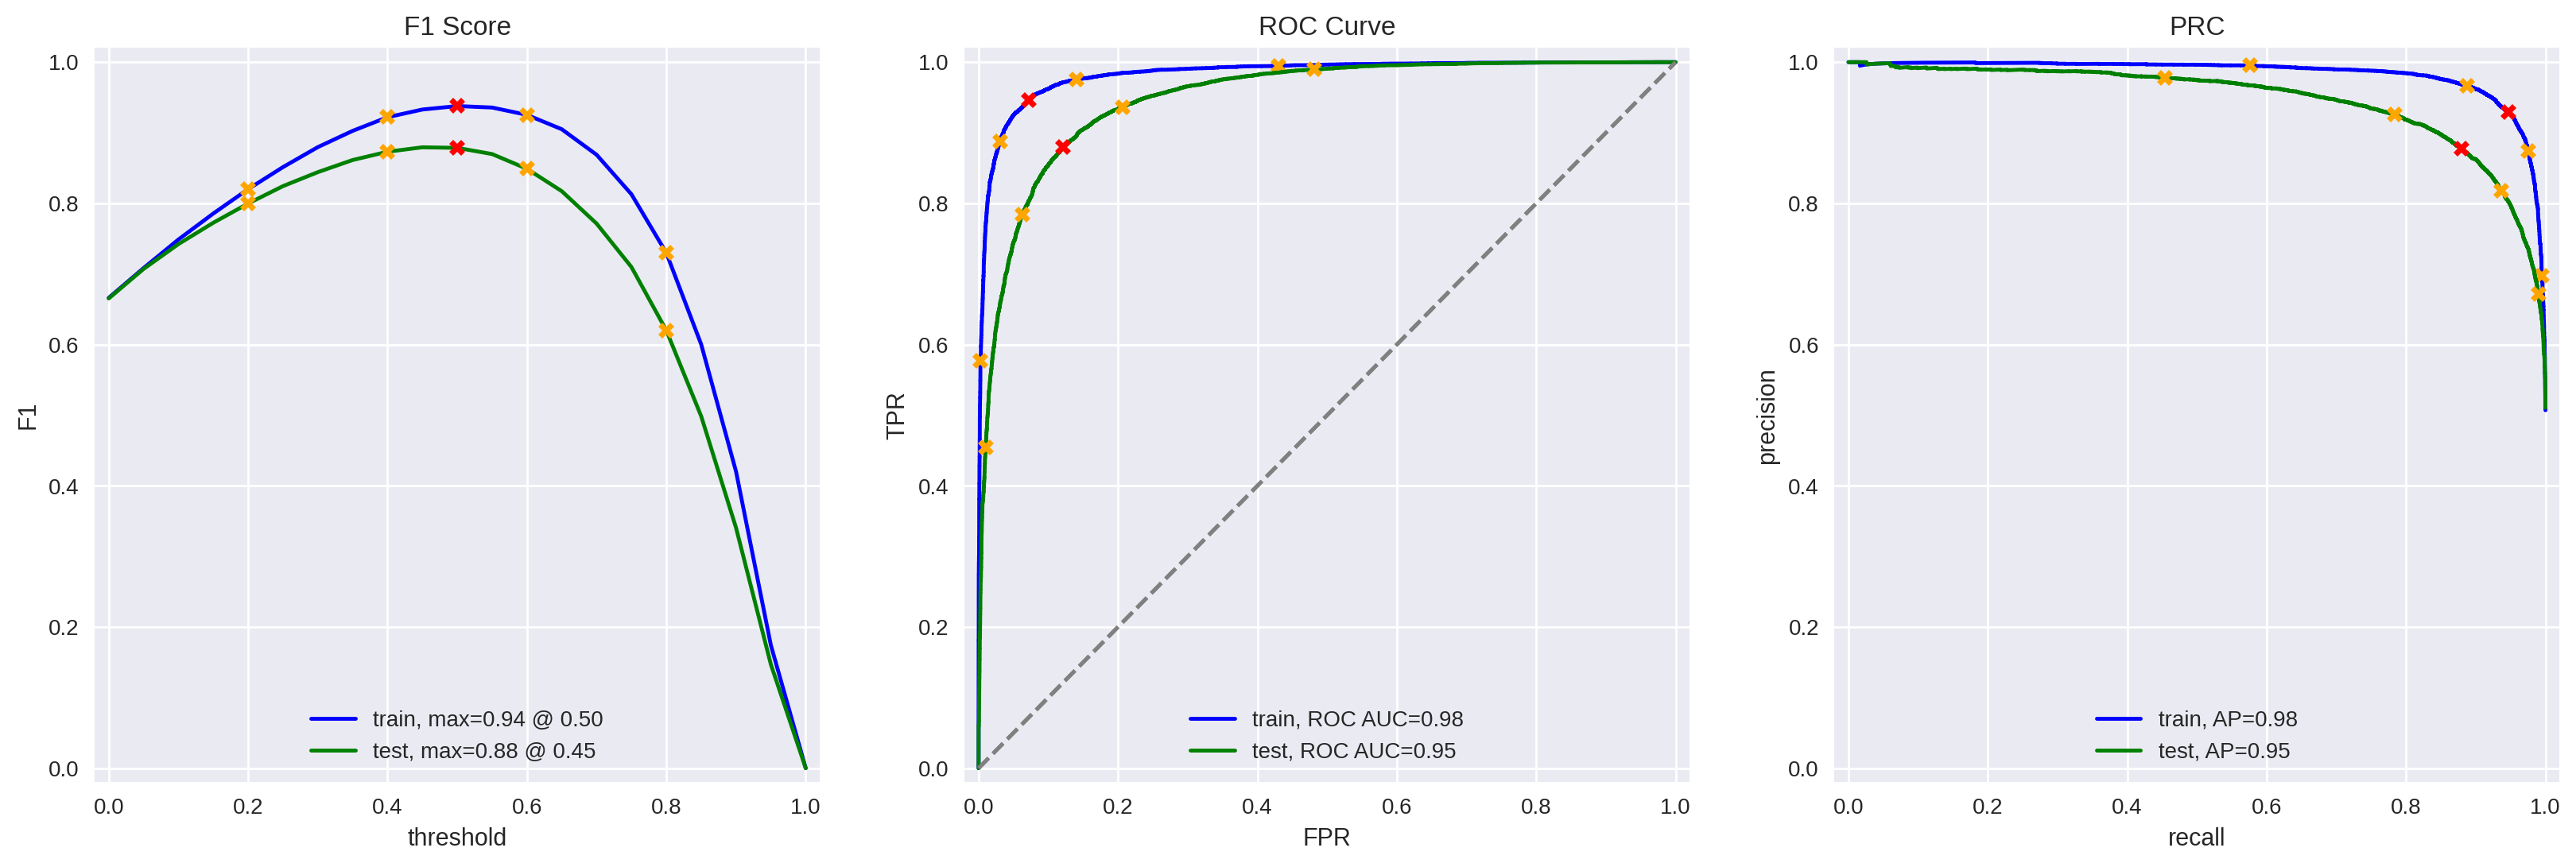

In [30]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

Our F1 test score came to 0.88, the same as our previous model.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [31]:
from lightgbm import LGBMClassifier

In [32]:
model_4 = LGBMClassifier(random_state=42, n_jobs=-1)

model_4.fit(train_features_3, train_target)

LGBMClassifier(random_state=42)

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


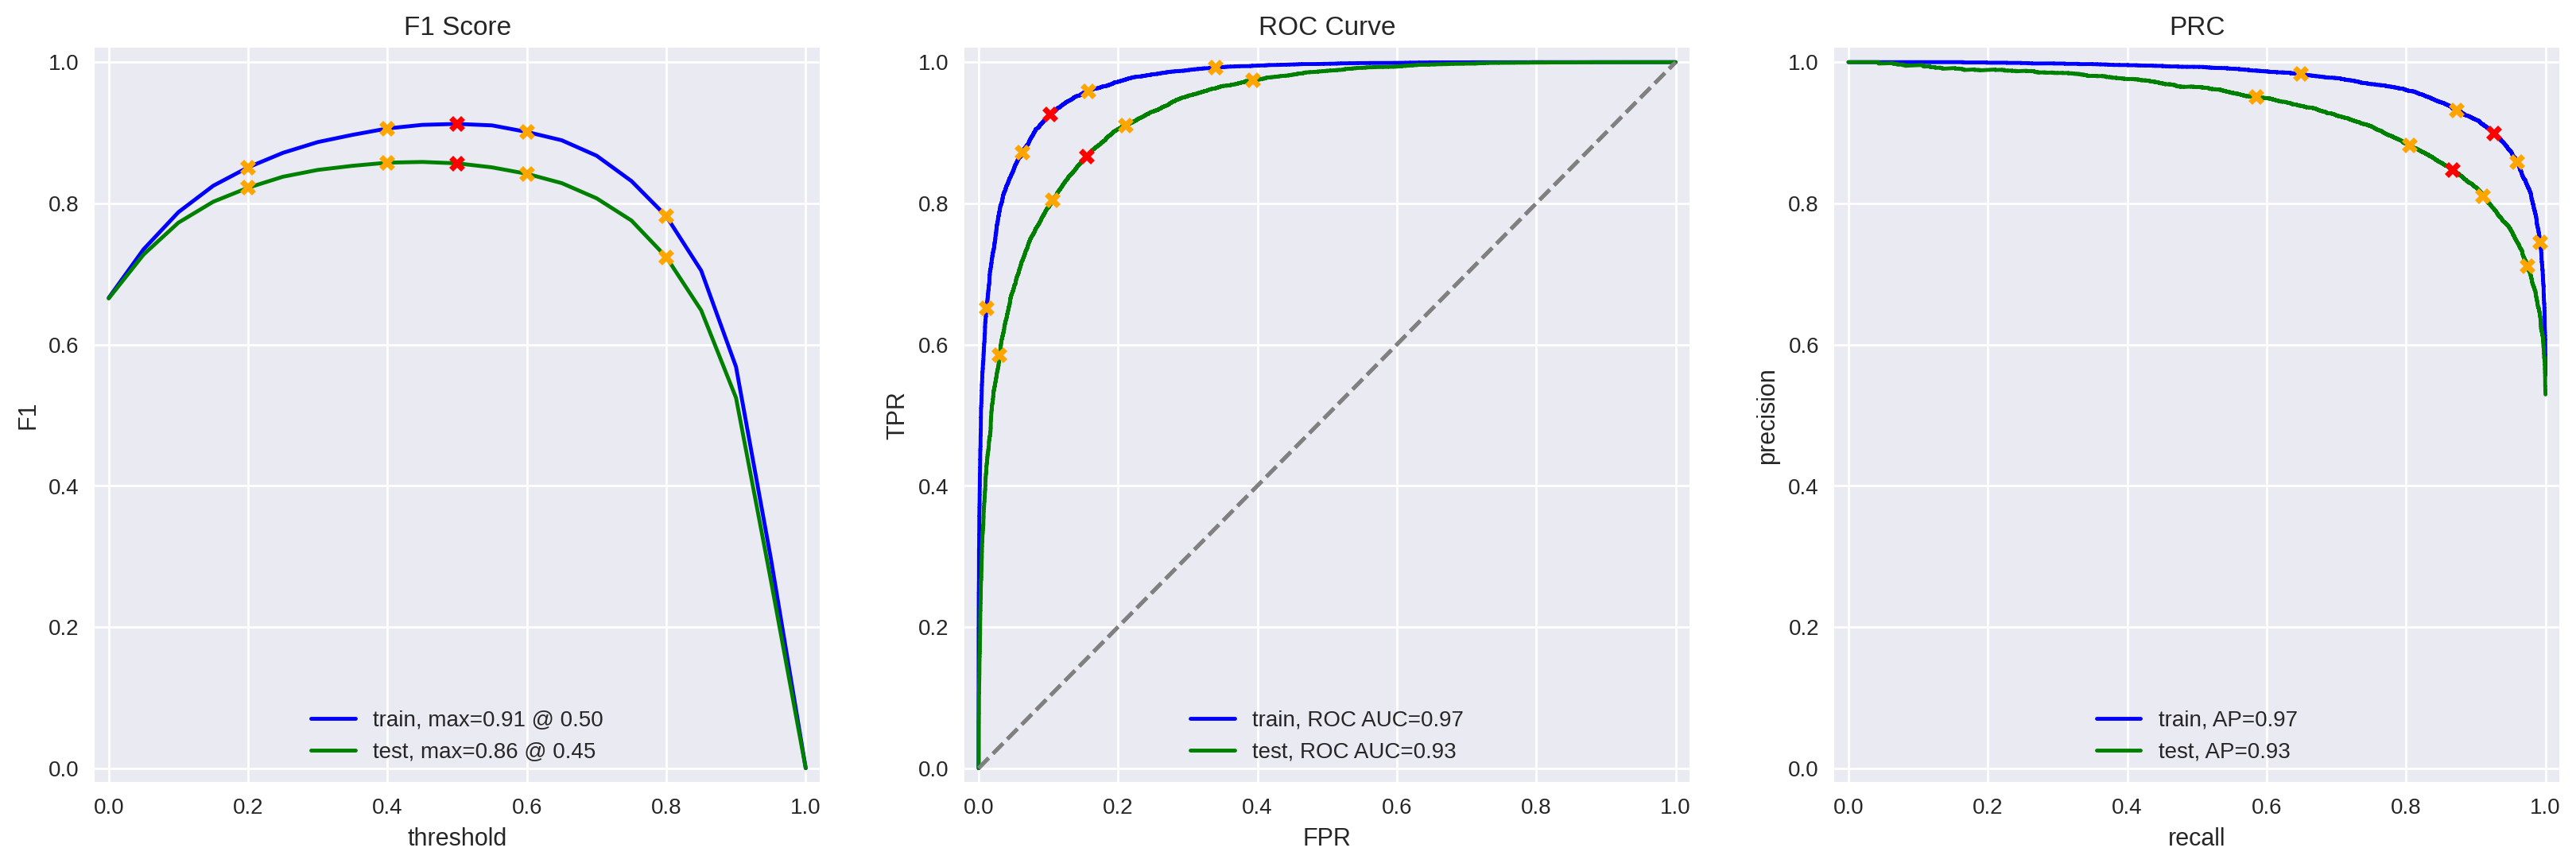

In [33]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

We still hit our 0.85 F1 score goal, but this was the lowest score of our models so far. (I tried building a BERT model, but it was taking a very long time, so I took out this part.)

## My Reviews

In [2]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])


my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub(r'[^a-z\s]', '', x.lower()))


my_reviews

NameError: name 'pd' is not defined

### Model 1

In [35]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.09:  i did not simply like it not my kind of movie
0.07:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.18:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didnt expect the reboot to be so good writers really cared about the source material
0.42:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3

In [36]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.06:  i did not simply like it not my kind of movie
0.06:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.24:  i didnt expect the reboot to be so good writers really cared about the source material
0.42:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


/opt/conda/envs/python3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


### Model 4

In [37]:
texts = my_reviews['review_norm']

vectorizer_4 = vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.47:  i did not simply like it not my kind of movie
0.35:  well i was bored and felt asleep in the middle of the movie
0.61:  i was really fascinated with the movie
0.40:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.49:  i didnt expect the reboot to be so good writers really cared about the source material
0.59:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.25:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.69:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Conclusions

Looking at our F1 scores and the ratings our models provided to our reviews, we can see that Models 1 and 3 are both fairly accurate and exceeded our F1 score goal. Model 4 was not as accurate and it is obvious from looking at the reviews, but all three have much higher F1 scores than our dummy model. Model 1 is our best model, so we will save that model.

In [38]:
import joblib
joblib.dump(model_1, 'model_1.joblib')

['model_1.joblib']